In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
dist_central = np.loadtxt("CustDist_WHCentral.csv", skiprows=1, delimiter=",")[:,1:]
xy_central   = np.loadtxt("CustXY_WHCentral.csv", skiprows=1, delimiter=",")[:,1:].T

dist_corner  = np.loadtxt("CustDist_WHCorner.csv", skiprows=1, delimiter=",")[:,1:]
xy_corner    = np.loadtxt("CustXY_WHCorner.csv", skiprows=1, delimiter=",")[:,1:].T

orders       = np.loadtxt("CustOrd.csv", skiprows=1, delimiter=",")[:,1]

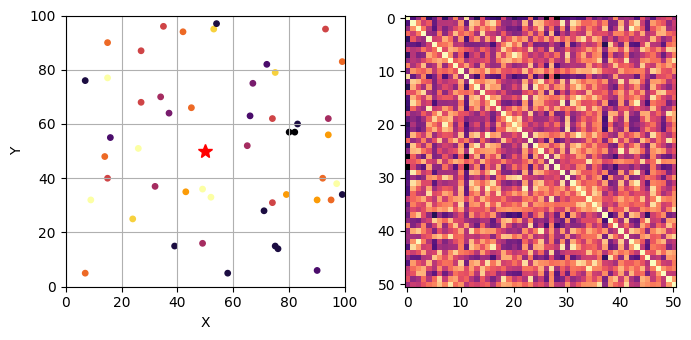

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3.5))

ax[0].set(xlabel="X", ylabel="Y", xlim=(0,100), ylim=(0,100))

ax[0].scatter(xy_central[0][1:], xy_central[1][1:], marker="o", s=15, c=orders[1:], cmap="inferno_r")
ax[0].plot(xy_central[0][0], xy_central[1][0], ls="", marker="*", ms=10, c="red")
ax[0].grid()

im = ax[1].imshow(dist_corner, cmap="magma_r")
# fig.colorbar(im, ax=ax[1])#, label='Interactive colorbar')
plt.tight_layout()

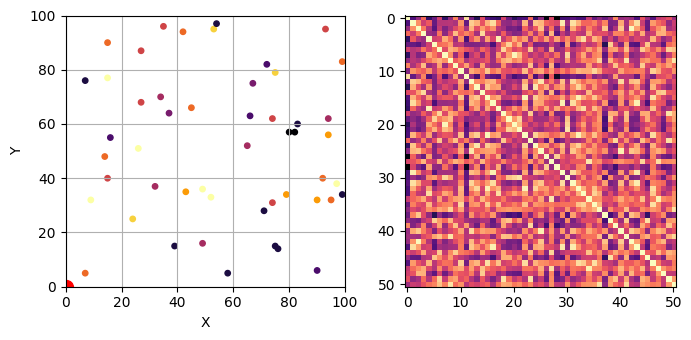

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3.5))

ax[0].set(xlabel="X", ylabel="Y", xlim=(0,100), ylim=(0,100))

ax[0].scatter(xy_corner[0][1:], xy_corner[1][1:], marker="o", s=15, c=orders[1:], cmap="inferno_r")
ax[0].plot(xy_corner[0][0], xy_corner[1][0], ls="", marker="o", ms=10, c="red")
ax[0].grid()

im = ax[1].imshow(dist_corner, cmap="magma_r")
# fig.colorbar(im, ax=ax[1])#, label='Interactive colorbar')
plt.tight_layout()

In [13]:
import random

from deap import base
from deap import creator
from deap import tools

In [52]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

IND_SIZE = 10

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(1, IND_SIZE+1), IND_SIZE)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [57]:
def evaluate(individual, distances, orders, max_capacity=1000):
    
    dist = distances[0, individual[0]]
    capacity = max_capacity - orders[individual[0]]
    
    for i, f in zip(individual[:-1], individual[1:]):
        if capacity < orders[f]:
            dist += distances[i][0]
            capacity = max_capacity
            dist += distances[0][f]
            # print("Ups, go back")
        else:
            dist += distances[i][f]
        
        capacity -= orders[f]
        # print(f"Went from {i} to {f} and capacity is now {capacity} and dist is {dist}")        

    return (dist,)
toolbox.register("evaluate", evaluate)

In [109]:
def PMX(ind1, ind2):
    ind1 -= 1
    ind2 -= 1
    tools.cxPartialyMatched(ind1, ind2)
    ind1 += 1
    ind2 += 1

    return (ind1, ind2)

toolbox.register("mate",   PMX)
toolbox.register("select", tools.selTournament, tournsize=3)    

# EVOLUTION

In [113]:
POP_SIZE = 50
CITIES = IND_SIZE
CXPB = 0.5


population = toolbox.population(n=POP_SIZE)

fitnesses = list(map(lambda I: toolbox.evaluate(I, dist_central[:CITIES+1], orders[:CITIES+1]), population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

In [114]:
np.mean(fitnesses), np.min(fitnesses), np.max(fitnesses)

(511.98, 393.0, 641.0)

In [115]:
fitnesses

[(571.0,),
 (569.0,),
 (529.0,),
 (555.0,),
 (473.0,),
 (641.0,),
 (496.0,),
 (541.0,),
 (524.0,),
 (543.0,),
 (538.0,),
 (519.0,),
 (532.0,),
 (570.0,),
 (498.0,),
 (491.0,),
 (555.0,),
 (514.0,),
 (554.0,),
 (524.0,),
 (442.0,),
 (502.0,),
 (539.0,),
 (473.0,),
 (466.0,),
 (442.0,),
 (507.0,),
 (536.0,),
 (569.0,),
 (536.0,),
 (465.0,),
 (545.0,),
 (549.0,),
 (526.0,),
 (476.0,),
 (549.0,),
 (506.0,),
 (491.0,),
 (495.0,),
 (498.0,),
 (484.0,),
 (498.0,),
 (502.0,),
 (470.0,),
 (415.0,),
 (393.0,),
 (524.0,),
 (462.0,),
 (444.0,),
 (558.0,)]

In [112]:
g = 0
while g < 10_000/POP_SIZE:
    g += 1
    print(f"----- Generation {g} -----")
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # for mutant in offspring:
    #     if random.random() < MUTPB:
    #         toolbox.mutate(mutant)
    #         del mutant.fitness.values
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = list(map(lambda I: toolbox.evaluate(I, dist_central[:CITIES+1], orders[:CITIES+1]), population))
    
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    population[:] = offspring
        # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in population]

    mean = np.mean(fits)
    std  = np.std(fits)

    print(f"Min {min(fits)}")
    print(f"Max {max(fits)}")
    print(f"Avg {mean}")
    print(f"Std {std}")

----- Generation 1 -----
Min 364.0
Max 597.0
Avg 484.4
Std 48.07577352471825
----- Generation 2 -----
Min 369.0
Max 580.0
Avg 460.3
Std 44.56287692687715
----- Generation 3 -----
Min 369.0
Max 597.0
Avg 449.64
Std 46.35677296792778
----- Generation 4 -----
Min 369.0
Max 568.0
Avg 449.88
Std 45.53620098339343
----- Generation 5 -----
Min 369.0
Max 532.0
Avg 444.78
Std 42.839836600995575
----- Generation 6 -----
Min 369.0
Max 549.0
Avg 450.52
Std 49.573073336237684
----- Generation 7 -----
Min 369.0
Max 583.0
Avg 454.22
Std 59.64135813342952
----- Generation 8 -----
Min 369.0
Max 580.0
Avg 446.2
Std 66.05815619588546
----- Generation 9 -----
Min 369.0
Max 592.0
Avg 458.04
Std 66.161608202945
----- Generation 10 -----
Min 369.0
Max 592.0
Avg 456.94
Std 68.83731836729261
----- Generation 11 -----
Min 369.0
Max 557.0
Avg 448.72
Std 63.6914562559218
----- Generation 12 -----
Min 369.0
Max 576.0
Avg 477.32
Std 63.06708808879636
----- Generation 13 -----
Min 369.0
Max 581.0
Avg 480.4
Std 68.70

In [95]:
toolbox.select(population, len(population))

[Individual([ 2,  6,  5,  4,  8,  1,  9,  7, 10,  3]),
 Individual([ 9,  8,  3,  7,  4,  6, 10,  1,  2,  5]),
 Individual([ 6,  9,  4,  3,  7,  2, 10,  5,  8,  1]),
 Individual([ 9,  8,  3,  7,  4,  6, 10,  1,  2,  5]),
 Individual([ 6,  9,  4,  3,  7,  2, 10,  5,  8,  1])]

In [96]:
population

[Individual([ 9,  8,  3,  7,  4,  6, 10,  1,  2,  5]),
 Individual([ 2,  6,  5,  4,  8,  1,  9,  7, 10,  3]),
 Individual([ 9,  3,  1,  5, 10,  6,  7,  2,  8,  4]),
 Individual([10,  7,  8,  2,  9,  6,  4,  3,  5,  1]),
 Individual([ 6,  9,  4,  3,  7,  2, 10,  5,  8,  1])]

SyntaxError: illegal expression for augmented assignment (612322518.py, line 2)

In [67]:
def add1(ind):
    ind+=1

add1(population[0])

In [68]:
population

[Individual([10,  7,  8,  5,  2,  6,  9, 11,  3,  4]),
 Individual([ 6,  7,  8,  5,  1,  3,  9, 10,  2,  4]),
 Individual([10,  9,  8,  5,  3,  2,  1,  6,  7,  4]),
 Individual([ 4,  5,  3,  1,  2,  8,  6,  9,  7, 10]),
 Individual([ 5,  1,  4,  7,  6, 10,  3,  8,  2,  9]),
 Individual([ 6,  1,  5, 10,  4,  3,  2,  7,  9,  8]),
 Individual([ 6, 10,  5,  9,  3,  7,  4,  1,  2,  8]),
 Individual([ 3,  9,  6,  5, 10,  2,  8,  7,  4,  1]),
 Individual([ 4,  7,  3,  9,  5,  2, 10,  6,  8,  1]),
 Individual([10,  5,  8,  4,  7,  2,  6,  1,  9,  3]),
 Individual([ 6,  4,  2,  5, 10,  1,  7,  3,  8,  9]),
 Individual([ 2,  6,  7,  5,  3,  9,  1,  8,  4, 10]),
 Individual([ 4,  2,  5, 10,  8,  1,  6,  9,  3,  7]),
 Individual([ 3,  6,  8, 10,  9,  7,  2,  5,  1,  4]),
 Individual([ 6,  9,  3,  1, 10,  5,  7,  8,  4,  2]),
 Individual([ 9,  7,  4,  6,  5,  1,  2,  8,  3, 10]),
 Individual([ 5,  4,  6, 10,  9,  1,  7,  3,  2,  8]),
 Individual([ 8,  6,  1, 10,  7,  3,  5,  9,  2,  4]),
 Individua